# 1. Setup

The following is adapted from the "BERT Fine-Tuning Turorial with Pytorch" notebook created by Chris McCormick and Nick Ryan to work with a RoBERTa model, and our MultiFC dataset. The link the original notebook can be found at https://mccormickml.com/2019/07/22/BERT-fine-tuning/

## 1.1. Using Colab GPU for Training



Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In [0]:
!nvidia-smi

Fri May 15 03:10:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [0]:
import torch
device = torch.device("cpu")

In [0]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [0]:
torch.cuda.empty_cache()

## 1.2. Installing the Hugging Face Library



Next, let's install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give us a pytorch interface for working with BERT. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to your specific task. For example, in this tutorial we will use `BertForSequenceClassification`.

The library also includes task-specific classes for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.


In [0]:
!pip install transformers

     |████████████████████████████████| 645kB 2.8MB/s 
     |████████████████████████████████| 890kB 14.5MB/s 
     |████████████████████████████████| 3.8MB 19.8MB/s 
     |████████████████████████████████| 1.1MB 35.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=6b2ad0f3938e9d71a4dcf0ccf6acd295f061700848bc663c43673d7c5eaf6d93
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


The code in this notebook is actually a simplified version of the [run_glue.py](https://github.com/huggingface/transformers/blob/master/examples/run_glue.py) example script from huggingface.

`run_glue.py` is a helpful utility which allows you to pick which GLUE benchmark task you want to run on, and which pre-trained model you want to use (you can see the list of possible models [here](https://github.com/huggingface/transformers/blob/e6cff60b4cbc1158fbd6e4a1c3afda8dc224f566/examples/run_glue.py#L69)). It also supports using either the CPU, a single GPU, or multiple GPUs. It even supports using 16-bit precision if you want further speed up.

Unfortunately, all of this configurability comes at the cost of *readability*. In this Notebook, we've simplified the code greatly and added plenty of comments to make it clear what's going on. 

# 2. Loading MultiFC Dataset


## 2.1. Download & Extract

We'll use the `wget` package to download the dataset to the Colab instance's file system. 

In [0]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=13f9995e000d6497aa80c871295ef7922cd505623baa65cfa1a7f382fb88cd5d
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://competitions.codalab.org/my/datasets/download/4db8bf21-def7-4a86-99f5-7b23d5691bb3'

# Download the file (if we haven't already)
if not os.path.exists('multi-fc/'):
    !mkdir multi-fc
    wget.download(url, 'multi-fc/multi-fc.zip')
    !unzip multi-fc/multi-fc.zip -d multi-fc/

Streaming output truncated to the last 5000 lines.
  inflating: multi-fc/snippets/snes-06270  
  inflating: multi-fc/snippets/snes-06271  
  inflating: multi-fc/snippets/snes-06272  
  inflating: multi-fc/snippets/snes-06273  
  inflating: multi-fc/snippets/snes-06274  
  inflating: multi-fc/snippets/snes-06275  
  inflating: multi-fc/snippets/snes-06276  
  inflating: multi-fc/snippets/snes-06277  
  inflating: multi-fc/snippets/snes-06278  
  inflating: multi-fc/snippets/snes-06279  
  inflating: multi-fc/snippets/snes-06280  
  inflating: multi-fc/snippets/snes-06281  
  inflating: multi-fc/snippets/snes-06282  
  inflating: multi-fc/snippets/snes-06283  
  inflating: multi-fc/snippets/snes-06284  
  inflating: multi-fc/snippets/snes-06285  
  inflating: multi-fc/snippets/snes-06286  
  inflating: multi-fc/snippets/snes-06287  
  inflating: multi-fc/snippets/snes-06288  
  inflating: multi-fc/snippets/snes-06289  
  inflating: multi-fc/snippets/snes-06290  
  inflating: multi-fc/sni

## 2.2. Parse

We can see from the file names that both `tokenized` and `raw` versions of the data are available. 

We can't use the pre-tokenized version because, in order to apply the pre-trained BERT, we *must* use the tokenizer provided by the model. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

We'll use pandas to parse the "in-domain" training set and look at a few of its properties and data points.

In [0]:
import pandas as pd
import csv

# Load the dataset into a pandas dataframe.
train_df = pd.read_csv("multi-fc/train.tsv", delimiter='\t', header=None, quoting=csv.QUOTE_NONE, \
                 names= ['claimID', 'claim', 'label', 'claimURL', 'reason', 'categories', 'speaker', \
                  'checker', 'tags', 'articleTitle', 'publishDate', 'claimDate', 'entities'])

dev_df = pd.read_csv("multi-fc/dev.tsv", delimiter='\t', header=None, quoting=csv.QUOTE_NONE, \
                 names= ['claimID', 'claim', 'label', 'claimURL', 'reason', 'categories', 'speaker', \
                  'checker', 'tags', 'articleTitle', 'publishDate', 'claimDate', 'entities'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

# Report the number of sentences.
print('Number of dev sentences: {:,}\n'.format(dev_df.shape[0]))

# Display 2 random rows from the data.
train_df.head()

Number of training sentences: 27,940

Number of dev sentences: 3,493



,claimID,claim,label,claimURL,reason,categories,speaker,checker,tags,articleTitle,publishDate,claimDate,entities
0,pomt-03627,"""Six out of 10 of the highest unemployment rat...",half-true,/ohio/statements/2013/may/06/chris-redfern/ohi...,When a couple of Statehouse Republicans prepar...,None,Chris Redfern,None,None,None,2013-05-06T06:00:00,2013-04-30,['None']
1,pomt-09611,"""No Democratic campaign for (Fla.) governor ha...",true,/florida/statements/2010/jan/15/alex-sink/flor...,Florida's leading Republican candidate for gov...,None,Alex Sink,None,None,None,2010-01-15T13:59:00,2010-01-06,['None']
2,tron-00214,Forward an email for Jasmine,fiction!,https://www.truthorfiction.com/jasmine/,None,9-11-attack,None,None,None,Forward an email for Jasmine,"Mar 17, 2015",None,['None']
3,snes-04484,Pope Francis endorsed Donald Trump for president.,false,https://www.snopes.com/fact-check/pope-francis...,None,Junk News,None,Dan Evon,None,"Pope Francis Shocks World, Endorses Donald Tru...",10 July 2016,None,['None']
4,pomt-06704,Says Ron Paul insisted FEMA should be shut down.,true,/texas/statements/2011/sep/03/maureen-dowd/mau...,Commenting on the federal response to Hurrican...,None,Maureen Dowd,None,None,None,2011-09-03T06:00:00,2011-08-30,['None']


In [0]:
train_df = train_df.append(dev_df,ignore_index=True)

In [0]:
def generate_domain_df(df):
    getDomain = lambda x: x[:4]
    return df['claimID'].apply(getDomain).reset_index().rename(columns={"claimID": "domain"})

In [0]:
def sample_df(df, sample_frac=0.1):
    getDomain = lambda x: x[:4]
    df['domain'] = df['claimID'].apply(getDomain)
    df = df.groupby('domain').apply(lambda x: x.sample(frac = sample_frac))
    df.reset_index(drop=True,inplace=True)
    df.drop(columns=['domain'],inplace=True)
    return df

In [0]:
def drop_malformed(df):
    return df.dropna(subset=['claim']).reset_index()

Adding getSnippets() method - Taking only the major snippet - made changes to either take the major snippet or create an empty snippet list


In [0]:
def get_snippets(claimID):
  snippets = []
  try:
    f=open("multi-fc/snippets/{claimID}".format(claimID=claimID), "r")
    line = f.readline()
    split = line.split("\t")

    if len(split) ==1 and split[0]=='':
      snippets = []
    else:
      snippet = split[2]
      snippets.append(snippet)
    
    return snippets
  except FileNotFoundError:
    ##claimID did not have any snippets (we have 3875 / len(train) instances of this)
    return snippets


In [0]:
# trying with one instance 

# comment out later
snippets = []
m = open("multi-fc/snippets/{claimID}".format(claimID='pomt-03627'), "r")
line = m.readline()
split = line.split("\t")
split

l = ['']
if len(l) == 1 and l[0] == '':
    print("string was empty") 
# snippet = split[2]
# snippet
# snippets.append(snippet)
# snippets

s = []
if not s:
  print("Works")

string was empty
Works


In [0]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(train_df['label'])

LabelEncoder()

In [0]:
# train_df = sample_df(train_df)

In [0]:
import numpy as np
train_df = train_df.replace(np.nan,'NaN',regex=True)

In [0]:
#gives original train and dev DFs with just the bad claims dropped
train_df = drop_malformed(train_df)
#dev_df = drop_malformed(dev_df)

In [0]:
##gives df of domain for every claim
train_domains = generate_domain_df(train_df)
#dev_domains = generate_domain_df(dev_df)

##maps domain name to id from 0 to domains - 1 
domain_to_domain_id = {k: v for v, k in enumerate(train_domains.domain.unique())}

## replaces domain name column with domain id
train_domains = train_domains.replace({'domain': domain_to_domain_id})
#dev_domains = dev_domains.replace({'domain': domain_to_domain_id})

In [0]:
len(train_df[['claim']])

31433

In [0]:
## creates dataframe with claim, index, domain id
train_claims = pd.concat([train_df[['claim']], train_domains], axis=1)
#dev_claims = pd.concat([dev_df[['claim']], dev_domains], axis=1)


In [0]:
##gives dfs with label, index, domain_id
train_labels = pd.concat([train_df['label'], train_domains], axis=1)
#dev_labels = pd.concat([dev_df['label'], dev_domains], axis=1)

##creates dictionary mapping domain_id to all possible labels within domain
train_labels_map_to_domain = train_labels.groupby('domain')['label'].apply(set).apply(list).to_dict()
#dev_labels_map_to_domain = dev_labels.groupby('domain')['label'].apply(set).apply(list).to_dict()

##maps possible labels within to domain to 0 to num_labels-1
for domain in train_labels_map_to_domain:
    train_labels_map_to_domain[domain] = {k: v for v, k in enumerate(train_labels_map_to_domain[domain])} 



## creates list of size len(train) and len(dev) where each label is mapped to its' value within its' domain as per previous code
original_train_labels = train_labels
train_labels = []
##original_dev_labels = dev_labels
dev_labels = []
for index, row in original_train_labels.iterrows():
    train_labels.append(train_labels_map_to_domain[row.domain][row.label])
#for index, row in original_dev_labels.iterrows():
    #dev_labels.append(train_labels_map_to_domain[row.domain][row.label])

In [0]:
## creates dfs with label_id, index, domain per row (claim) and dictionary mapping
train_lab_dom = pd.concat([pd.DataFrame(train_labels, columns=['label_id']), train_domains], axis=1)
train_domain_label_map = train_lab_dom.groupby('domain')['label_id'].apply(set).to_dict()

#dev_lab_dom = pd.concat([pd.DataFrame(dev_labels, columns=['label_id']), dev_domains], axis=1)
#dev_domain_label_map = dev_lab_dom.groupby('domain')['label_id'].apply(set).to_dict()

domain_label_map = train_domain_label_map

In [0]:
train_lab_dom.head()

,label_id,index,domain
0,2,0,0
1,1,1,0
2,18,2,1
3,0,3,2
4,1,4,0


In [0]:
domain_label_map

{0: {0, 1, 2, 3, 4, 5, 6, 7, 8},
 1: {0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26},
 2: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11},
 3: {0, 1, 2, 3, 4, 5, 6, 7},
 4: {0, 1, 2},
 5: {0, 1, 2, 3, 4, 5},
 6: {0, 1, 2, 3, 4, 5},
 7: {0, 1, 2, 3},
 8: {0, 1, 2, 3, 4, 5},
 9: {0, 1, 2, 3, 4, 5, 6},
 10: {0, 1, 2, 3, 4, 5, 6},
 11: {0, 1},
 12: {0, 1, 2, 3, 4, 5, 6},
 13: {0, 1, 2},
 14: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
 15: {0, 1, 2, 3},
 16: {0, 1, 2, 3, 4, 5},
 17: {0, 1, 2},
 18: {0, 1, 2, 3, 4, 5, 6},
 19: {0, 1, 2, 3, 4},
 20: {0, 1, 2},
 21: {0, 1, 2},
 22: {0, 1},
 23: {0, 1, 2, 3},
 24: {0, 1, 2},
 25: {0, 1, 2}}

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

## 3.1. RoBERTa Tokenizer

In [0]:
from transformers import RobertaTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Loading BERT tokenizer...


## 3.3. Tokenize Dataset

The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

An additional for loop will be added for claims that have snippets

NOTE: for claims without snippets, we pass in "tokenizer.unk_token" as the text_pair for argument for the encode_plus method

In [0]:
tokenizer.unk_token == '<unk>'

True

In [0]:
max_len = 0

# For every sentence...
for index, row in train_claims.iterrows():
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    claimID = train_df.iloc[index]['claimID']
    snippets = get_snippets(claimID)
    if(not snippets):
      input_ids = tokenizer.encode(text=row.claim,text_pair = tokenizer.unk_token, add_special_tokens=True)
      max_len = max(max_len, len(input_ids))
    else:
      for snippet in snippets:
        if(snippet==''):
          snippet = tokenizer.unk_token
        input_ids = tokenizer.encode(text=row.claim,text_pair = snippet, add_special_tokens=True) 
        max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (629 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1310 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  1315


In [0]:
train_df.iloc[12200]

index                                                       12200
claimID                                                bove-00197
claim                                                         NaN
label                                                        none
claimURL        https://www.boomlive.in/viral-message-claiming...
reason                                                        NaN
categories                                                   None
speaker                                                      None
checker                                                      None
tags                                                         None
articleTitle    Viral Message Claiming Combiflam Can Kill You ...
publishDate     Sep 05 2017 1:18 pm, Last Updated: Sep 07 2017...
claimDate                                                    None
entities                                                 ['None']
Name: 12200, dtype: object

In [0]:
claimID = train_df.iloc[1]['claimID']
snippets = get_snippets(claimID)
print(train_df.iloc[1]['claim'])
print(snippet)
# Print the original sentence.
# print(' Original: ', train_claims.head())

# # Print the sentence split into tokens.
# print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# # Print the sentence mapped to token ids.
# print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

"No Democratic campaign for (Fla.) governor has ever had these kinds of resources this early on in an election cycle."
Oct 15, 2013 ... Further, the whale's trachea doesn't connect to the esophagus of the ... male of a  group becoming female when the female of the group dies. ... have been bigger  than Marlin, not smaller as depicted in the movie. .... There's always a few guys  whose minds are blown to learn girls don't pee out of the vagina.


Modifying to work with snippets, similar to above a second for loop will be added 

"train" boolean param added so we can properly index from original train or val (depending on val of boolean) to get claimID

NOTE: for claims without snippets, we pass in "tokenizer.unk_token" as the text_pair for argument for the encode_plus method

NOTE: unlike working with just claims, the return_token_type_ids param of encode_plus must be set to True, incorporating it will follow the same structure as input_ids and attention_masks (see below)

In [0]:
snippets = [tokenizer.unk_token]
for snippet in snippets:
  print(snippet)

<unk>


In [0]:
from torch.utils.data import TensorDataset
from collections import defaultdict

def encode_claims(df_claims, en_labels=None, input_seq_length=512,train=True):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = defaultdict(list)
    attention_masks = defaultdict(list)
    labels = defaultdict(list)
    #token_type_ids = defaultdict(list)

    datasets = {}
    domains_to_tensors = {}

    # For every sentence...
    for index, row in df_claims.iterrows():

        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.

      if(train):
        claimID = train_df.iloc[index]['claimID']
      else:
        claimID = test_df.iloc[index]['claimID']

      snippets = get_snippets(claimID)

       
      if(not snippets):
          snippets = [tokenizer.unk_token]
    
      for snippet in snippets:
          if(snippet==''):
            snippet = tokenizer.unk_token
          encoded_dict = tokenizer.encode_plus(
                            row.claim,
                            text_pair = snippet,             # Sentence to encode.
                            add_special_tokens = True,       # Add '[CLS]' and '[SEP]'
                            max_length = input_seq_length, # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,    # Construct attn. masks.
                            return_tensors = 'pt',          # Return pytorch tensors.
                        )

        # Add the encoded sentence to the list.    
          input_ids[row.domain].append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
          attention_masks[row.domain].append(encoded_dict['attention_mask'])

          

        # do the same with token_type_ids
          #token_type_ids[row.domain].append(encoded_dict['token_type_ids'])
          if(en_labels is not None):
            labels[row.domain].append(en_labels[index])

            
    for domain in domain_label_map:
        # Convert the lists into tensors.
        input_temp = torch.cat(input_ids[domain], dim=0)
        attention_masks_temp = torch.cat(attention_masks[domain], dim=0)
        #token_type_ids_temp = torch.cat(token_type_ids[domain],dim=0)
        if(en_labels is not None):
          labels_temp = torch.tensor(labels[domain])
        
          datasets[domain] = TensorDataset(input_temp, attention_masks_temp,labels_temp)
        else:
          datasets[domain] = TensorDataset(input_temp, attention_masks_temp)

    return datasets

In [0]:
train_datasets = encode_claims(train_claims, train_labels,train=True)
#dev_datasets = encode_claims(dev_claims, dev_labels,train=False)

In [0]:
train_datasets[0]

## 3.4. Training & Validation Split


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

train_dataloaders = {}
validation_dataloaders = {}

for idx, domain in enumerate(domain_label_map):

    # Create the DataLoaders for our training and validation sets.
    # We'll take training samples in random order. 
    train_dataloaders[domain] = DataLoader(
                train_datasets[domain],  # The training samples.
                sampler = RandomSampler(train_datasets[domain]), # Select batches randomly
                batch_size = batch_size # Trains with this batch size.
            )

    # For validation the order doesn't matter, so we'll just read them sequentially.
    #validation_dataloaders[domain] = DataLoader(
               # dev_datasets[domain], # The validation samples.
                #sampler = SequentialSampler( dev_datasets[domain]), # Pull out batches sequentially.
                #batch_size = batch_size # Evaluate with this batch size.
           # )

# 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

## 4.1. RoBertaForSequenceClassification

In [0]:
from torch import nn

class MultiLinear(nn.Module):
    def __init__(self, hidden_size, domain_label_map):
        super(MultiLinear, self).__init__()
        self.linear_models = {}
        for domain in domain_label_map:
            self.linear_models[domain] = nn.Linear(hidden_size, len(domain_label_map[domain])).to(device)

    def forward(self, domain, input):
        return self.linear_models[domain].forward(input)

In [0]:
from transformers import RobertaForSequenceClassification, RobertaModel
from torch.nn import CrossEntropyLoss

class RobertaForSequenceClassificationMultiDomain(RobertaForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.roberta = RobertaModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = MultiLinear(config.hidden_size, domain_label_map)
        self.init_weights()
        
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, \
        inputs_embeds=None, \
        m_labels=None,
        m_domain=None):
        """
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`, defaults to :obj:`None`):
            Labels for computing the sequence classification/regression loss.
            Indices should be in :obj:`[0, ..., config.num_labels - 1]`.
            If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).

    Returns:
        :obj:`tuple(torch.FloatTensor)` comprising various elements depending on the configuration (:class:`~transformers.BertConfig`) and inputs:
        loss (:obj:`torch.FloatTensor` of shape :obj:`(1,)`, `optional`, returned when :obj:`label` is provided):
            Classification (or regression if config.num_labels==1) loss.
        logits (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, config.num_labels)`):
            Classification (or regression if config.num_labels==1) scores (before SoftMax).
        hidden_states (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``config.output_hidden_states=True``):
            Tuple of :obj:`torch.FloatTensor` (one for the output of the embeddings + one for the output of each layer)
            of shape :obj:`(batch_size, sequence_length, hidden_size)`.

            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        attentions (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``config.output_attentions=True``):
            Tuple of :obj:`torch.FloatTensor` (one for each layer) of shape
            :obj:`(batch_size, num_heads, sequence_length, sequence_length)`.

            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.

    Examples::

        from transformers import BertTokenizer, BertForSequenceClassification
        import torch

        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

        input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
        labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids, labels=labels)

        loss, logits = outputs[:2]

        """

        outputs = self.roberta(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask,
                            inputs_embeds=inputs_embeds)

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(domain, pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        loss_fct = CrossEntropyLoss()

        if(m_labels is None):
          loss = 0
        else:
          loss = loss_fct(logits.view(-1, len(domain_label_map[m_domain.item()])), m_labels.view(-1))
        outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [0]:
from transformers import RobertaForSequenceClassification, AdamW, RobertaConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = RobertaForSequenceClassificationMultiDomain.from_pretrained(
    "roberta-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(le.classes_), # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda();

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [0]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 199 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias           (

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 3

total_steps = 0
for domain in domain_label_map:
    # Total number of training steps is [number of batches] x [number of epochs]. 
    # (Note that this is not the same as the number of training samples).
    total_steps += len(train_dataloaders[domain]) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

Define a helper function for calculating accuracy.

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
from sklearn.metrics import f1_score

def f1_macro(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat, average='macro')

def f1_micro(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat, average='micro')

Helper function for formatting elapsed times as `hh:mm:ss`


In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [0]:
print(epochs)



3


We're ready to kick off the training!

In [0]:
import random
import numpy as np
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    domains = list(domain_label_map.keys())
    random.shuffle(domains)

    dataloaders_iters = {}
    dataloader_batch_tracker = {}
    for domain in train_dataloaders:
        dataloaders_iters[domain] = iter(train_dataloaders[domain])
        dataloader_batch_tracker[domain] = 0
    train_domains_list = domains.copy()
    total_train_loss = 0
    step = 0

    while train_domains_list:
        domain = random.choice(train_domains_list)
        dataloader_batch_tracker[domain] += 1
        try:
            batch = next(dataloaders_iters[domain])
        except StopIteration: 
            train_domains_list.remove(domain)
            continue

        step += 1
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(dataloader_batch_tracker[domain], len(train_dataloaders[domain]), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains four pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: token type ids
        #   [3]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        #b_token_type_ids = batch[2].to(device)
        b_labels = batch[2].to(device)
        
        b_domain = torch.tensor([domain]).to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask, 
                            m_labels=b_labels,
                            m_domain=b_domain)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / step         
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # print("")
    # print("Running Validation...")

    # t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    # model.eval()

    # Tracking variables 
    # total_eval_accuracy = 0
    # total_eval_loss = 0
    # nb_eval_steps = 0

    # # F1 Scores
    # f1_macro_score = 0
    # f1_micro_score = 0

    # for domain in validation_dataloaders:
    #     dataloaders_iters[domain] = iter(validation_dataloaders[domain])
    #     dataloader_batch_tracker[domain] = 0
    # step = 0
    # validation_domains_list = domains.copy()

    # while validation_domains_list:
    #     step += 1
    #     domain = random.choice(validation_domains_list)
        
    #     try:
    #         batch = next(dataloaders_iters[domain])
    #     except StopIteration: 
    #         validation_domains_list.remove(domain)
    #         continue

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: token type ids 
        #   [3]: labels 
        # b_input_ids = batch[0].to(device)
        # b_input_mask = batch[1].to(device)
        # b_token_type_ids = batch[2].to(device)
        # b_labels = batch[3].to(device)
        # b_domain = torch.tensor([domain]).to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        # with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            # (loss, logits) = model(b_input_ids, 
            #                     token_type_ids=b_token_type_ids, 
            #                     attention_mask=b_input_mask,
            #                     m_labels=b_labels,
            #                     m_domain=b_domain)
            
        # Accumulate the validation loss.
        #total_eval_loss += loss.item()

        # Move logits and labels to CPU
        #logits = logits.detach().cpu().numpy()
        #label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
       # total_eval_accuracy += flat_accuracy(logits, label_ids)
        #f1_macro_score += f1_macro(logits, label_ids) 
        #f1_micro_score += f1_micro(logits, label_ids) 

    # Report the final accuracy for this validation run.
    # avg_val_accuracy = total_eval_accuracy / step
    # print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # # Report the final f1 macro score for this validation run.
    # avg_val_f1_macro = f1_macro_score / step
    # print("  F1 Macro: {0:.2f}".format(avg_val_f1_macro))

    # # Report the final f1 micro score for this validation run.
    # avg_val_f1_micro = f1_micro_score / step
    # print("  F1 Micro: {0:.2f}".format(avg_val_f1_micro))

    # # Calculate the average loss over all of the batches.
    # avg_val_loss = total_eval_loss / step

    # if(avg_val_loss < best_loss):
    #   best_loss = avg_val_loss
    #   torch.save(model.state_dict,'model.pth')


    # # Measure how long the validation run took.
    # validation_time = format_time(time.time() - t0)

    # print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    # print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            #'Valid. Loss': avg_val_loss,
            #'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            #'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  Batch     2  of     25.    Elapsed: 0:00:33.
  Batch     4  of     25.    Elapsed: 0:01:05.
  Batch     2  of      7.    Elapsed: 0:01:39.
  Batch     8  of     12.    Elapsed: 0:02:12.
  Batch    10  of     29.    Elapsed: 0:02:45.
  Batch    10  of     13.    Elapsed: 0:03:19.
  Batch    19  of     74.    Elapsed: 0:03:53.
  Batch    19  of     77.    Elapsed: 0:04:26.
  Batch    22  of     25.    Elapsed: 0:05:00.
  Batch    23  of     25.    Elapsed: 0:05:33.
  Batch    28  of    364.    Elapsed: 0:06:07.
  Batch    41  of     77.    Elapsed: 0:06:41.
  Batch    48  of    866.    Elapsed: 0:07:15.
  Batch    47  of    166.    Elapsed: 0:07:49.
  Batch    55  of     77.    Elapsed: 0:08:23.
  Batch    61  of    364.    Elapsed: 0:08:57.
  Batch    96  of    187.    Elapsed: 0:09:31.
  Batch   103  of    187.    Elapsed: 0:10:05.
  Batch   111  of    187.    Elapsed: 0:10:39.
  Batch    93  of    364.    Elapsed: 0:11:13.
  Batch    98  of    166.    Elapsed: 0:11:47.
  Batch   141

Let's view the summary of the training process.

In [0]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Training Time
epoch,,
1,1.55,0:27:54
2,1.39,0:27:56
3,1.27,0:27:59



#### NOT FOR MULTIFC

Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data. 

(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


KeyError: ignored

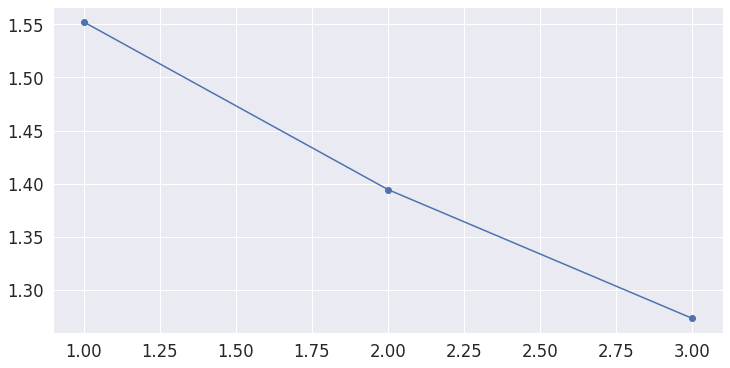

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [0]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

# 5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [0]:
import pandas as pd

test_df = pd.read_csv("multi-fc/test.tsv", delimiter='\t', header=None, quoting=csv.QUOTE_NONE, \
                 names= ['claimID', 'claim', 'claimURL', 'reason', 'categories', 'speaker', \
                  'checker', 'tags', 'articleTitle', 'publishDate', 'claimDate', 'entities'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

index_to_add = test_df.index[test_df.isnull()['claim'] == True].tolist()

test_df = drop_malformed(test_df)
print(len(test_df))

##gives df of domain for every claim
test_domains = generate_domain_df(test_df)
## replaces domain name column with domain id
test_domains = test_domains.replace({'domain': domain_to_domain_id})

test_claims = pd.concat([test_df[['claim']], test_domains], axis=1)

test_datasets = encode_claims(test_claims,train=False)

#Claim idx domain map used to correctly sort output
test_domain_idx_map = test_domains.groupby('domain')['index'].apply(list).to_dict()

Number of test sentences: 3,491

3490


In [0]:
test_dataloaders = {}

for idx, domain in enumerate(domain_label_map):

    # Create the DataLoaders for our test set.
    # For test the order doesn't matter, so we'll just read them sequentially.
    
    test_dataloaders[domain] = DataLoader(
                test_datasets[domain], # The validation samples.
                sampler = SequentialSampler( test_datasets[domain]), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )

## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [0]:
print("Running Testing...")

t0 = time.time()
predictions = []
pred_domains = []

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
model.eval()

for domain in test_dataloaders:
    dataloaders_iters[domain] = iter(test_dataloaders[domain])
    dataloader_batch_tracker[domain] = 0
step = 0
test_domains_list = domains.copy()

while test_domains_list:
    step += 1
    domain = random.choice(test_domains_list)
        
    try:
        batch = next(dataloaders_iters[domain])
    except StopIteration: 
        test_domains_list.remove(domain)
        continue
    
    pred_domains.append(domain)

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    # b_labels = batch[2].to(device)
    b_domain = torch.tensor([domain]).to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
        outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                m_domain=b_domain)
            
        # Accumulate the validation loss.
    logits = outputs[1]
  # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
  
  # Store predictions and true labels
    predictions.append(logits)

print('    DONE.')

Running Testing...
    DONE.


In [0]:
import itertools
y_pred = []
batch_sizes = []
for i in range(len(predictions)):
  
  # The predictions for this batch are a 5-column ndarray with a row for each batch (32). 
  #Pick the label with the highest value and consider the index = class
  pred_labels_i = list(np.argmax(predictions[i], axis=1))
  current_domain = train_labels_map_to_domain[pred_domains[i]]

  batch_sizes.append(len(pred_labels_i))
  for j in pred_labels_i:
    label = list(current_domain.keys())[list(current_domain.values()).index(j)]
    y_pred.append(label)

#Get domain respective to each prediction
domain_order = []
for idx, domain in enumerate(pred_domains):
  batch_size = batch_sizes[idx]
  for i in range(batch_size):
    domain_order.append(domain)

#Obtain claim index of each prediction
new_index = []
for domain in domain_order:
  new_index.append(test_domain_idx_map[domain][0])
  test_domain_idx_map[domain].pop(0)

#Sort predictions based on original index 
y_pred = [x for _,x in sorted(zip(new_index,y_pred))]

y_pred.insert(index_to_add[0],'false')
y_pred[0:5]

['false', 'false', 'miscaptioned', 'true', 'false']

In [0]:
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


In [0]:
!pwd

/content


In [0]:
with open('./test.predict', 'w') as filehandle:
    filehandle.writelines("%s\n" % pred for pred in y_pred)